# Análise de Soft Failures com LSTNet


## 1. Carregamento e Configuração Inicial

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GRU, Dense, Lambda, Add
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix

In [22]:
try:
    df = pd.read_csv(r'D:/Projetos/UFABC/UFABC_Tambra/Dados/SoftFailure_dataset.csv')
    df['Failure'] = df['Failure'].fillna(0).astype(int)
    print("Dataset de Soft Failure carregado com sucesso!")
    print(df.head())
except FileNotFoundError as e:
    print(e)

Dataset de Soft Failure carregado com sucesso!
    Timestamp            Type          ID           BER  OSNR  InputPower  \
0  1624457562         Devices  SPO1/18/11  2.310000e-08  38.6         NaN   
1  1624457562  Infrastructure      Ampli1           NaN   NaN       -19.2   
2  1624457562         Devices  SPO2/18/11  1.720000e-07  25.8         NaN   
3  1624457562  Infrastructure      Ampli3           NaN   NaN       -16.7   
4  1624457562  Infrastructure      Ampli2           NaN   NaN       -15.5   

   OutputPower  Failure  
0          NaN        0  
1          0.7        0  
2          NaN        0  
3          0.8        0  
4          0.4        0  


## 2. Pré-processamento dos Dados


In [23]:
features = df.drop(columns=['Timestamp', 'Type', 'ID', 'Failure'])

train_size = int(len(features) * 0.7)
val_size = int(len(features) * 0.1)
train_df = features[:train_size]
val_df = features[train_size:train_size + val_size]
test_df = features[train_size + val_size:]

scaler = MinMaxScaler()
scaler.fit(train_df)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps)])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

TIMESTEPS = 5
X_train, y_train = create_sequences(train_scaled, TIMESTEPS)
X_val, y_val = create_sequences(val_scaled, TIMESTEPS)
X_test, y_test = create_sequences(test_scaled, TIMESTEPS)

In [24]:
print("Shapes dos dados de treino (X, y):", X_train.shape, y_train.shape)
print("Shapes dos dados de validação (X, y):", X_val.shape, y_val.shape)
print("Shapes dos dados de teste (X, y):", X_test.shape, y_test.shape)

Shapes dos dados de treino (X, y): (37582, 5, 4) (37582, 4)
Shapes dos dados de validação (X, y): (5364, 5, 4) (5364, 4)
Shapes dos dados de teste (X, y): (10736, 5, 4) (10736, 4)


## 3. Construção do Modelo LSTNet

In [25]:
def build_lstnet_model(timesteps, n_features, conv_filters=10, kernel_size=3, gru_units=100):
    inputs = Input(shape=(timesteps, n_features))
    conv_out = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(inputs)
    gru_out = GRU(gru_units, activation='relu')(conv_out)
    gru_proj = Dense(n_features)(gru_out)
    ar_input = Lambda(lambda x: x[:, -1, :])(inputs)
    ar_out = Dense(n_features)(ar_input)
    combined = Add()([gru_proj, ar_out])
    outputs = combined
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
n_features = X_train.shape[2]
lstnet_model = build_lstnet_model(TIMESTEPS, n_features)
lstnet_model.compile(optimizer='adam', loss='mean_squared_error')
lstnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 5, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 3, 10)     │        130 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 100)       │     33,600 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 4)         │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │        404 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 4)         │         20 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 4)         │          0 │ dense_7[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,154 (133.41 KB)

 Trainable params: 34,154 (133.41 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Treinamento do Modelo

In [27]:
print("Iniciando o treinamento do modelo LSTNet para Soft Failures...")
history = lstnet_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Iniciando o treinamento do modelo LSTNet para Soft Failures...
Epoch 1/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: nan - val_loss: nan
Epoch 2/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 3/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 4/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 5/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 6/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 7/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 8/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 9/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 10/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 11/50
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 12/50
1175/1175 ━━━━━━━━━━━

## 5. Avaliação do Treinamento e Definição do Limiar de Anomalia

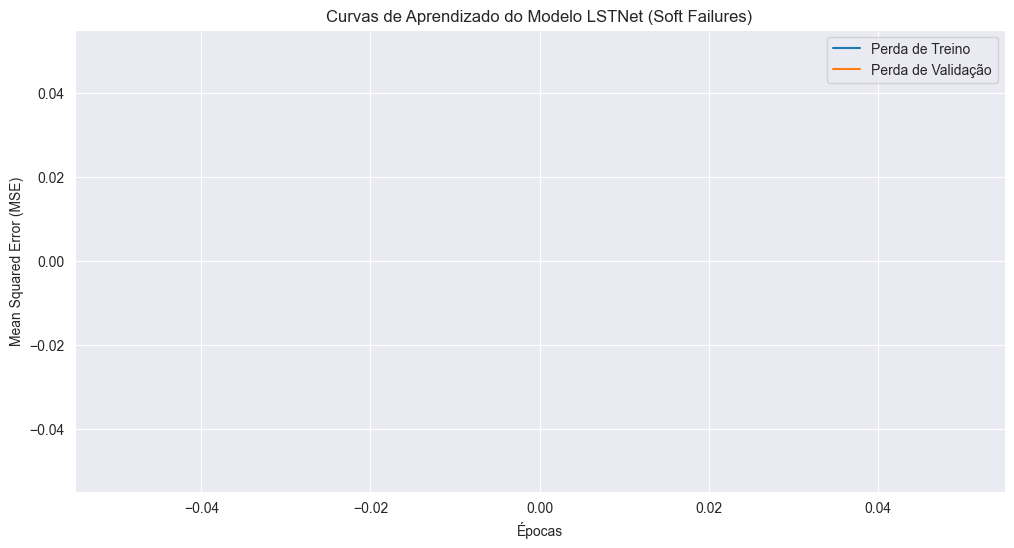

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Curvas de Aprendizado do Modelo LSTNet (Soft Failures)')
plt.xlabel('Épocas')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

1175/1175 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step

Limiar de Anomalia (Threshold) ajustado para 95% de confiança: nan


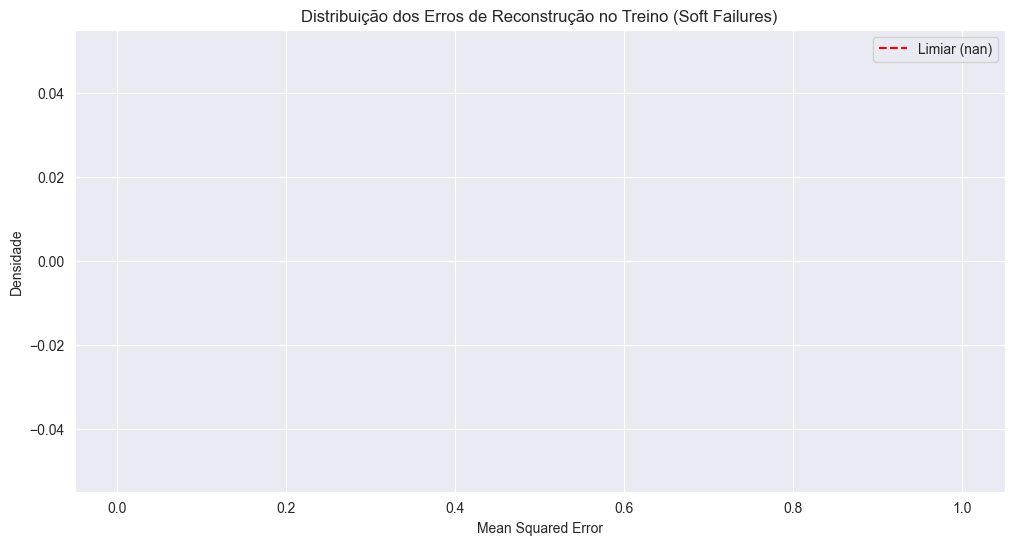

In [29]:
train_predictions = lstnet_model.predict(X_train)
train_mse = np.mean(np.square(train_predictions - y_train), axis=1)

threshold = np.quantile(train_mse, 0.95)

print(f"\nLimiar de Anomalia (Threshold) ajustado para 95% de confiança: {threshold:.5f}")

plt.figure(figsize=(12, 6))
sns.histplot(train_mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Limiar ({threshold:.5f})')
plt.title('Distribuição dos Erros de Reconstrução no Treino (Soft Failures)')
plt.xlabel('Mean Squared Error')
plt.ylabel('Densidade')
plt.legend()
plt.show()


## 6. Detecção de Falhas e Avaliação Final

In [30]:
test_predictions = lstnet_model.predict(X_test)
test_mse = np.mean(np.square(test_predictions - y_test), axis=1)
anomalies = test_mse > threshold

print(f"Total de amostras no teste: {len(X_test)}")
print(f"Número de anomalias detectadas: {np.sum(anomalies)}")

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
Total de amostras no teste: 10736
Número de anomalias detectadas: 0


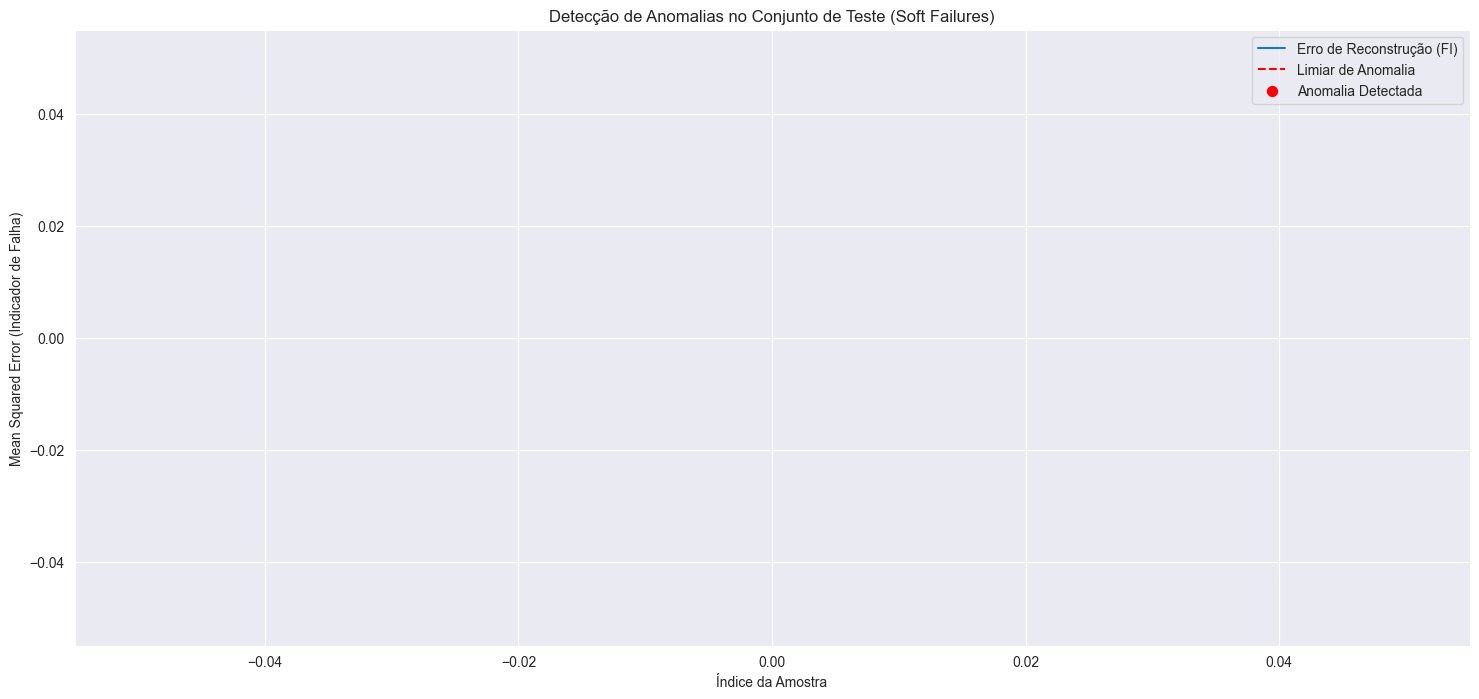

In [31]:
anomaly_df = pd.DataFrame(test_df[TIMESTEPS:])
anomaly_df['error'] = test_mse
anomaly_df['anomaly'] = anomalies

plt.figure(figsize=(18, 8))
plt.plot(anomaly_df.index, anomaly_df.error, label='Erro de Reconstrução (FI)')
plt.axhline(threshold, color='r', linestyle='--', label='Limiar de Anomalia')
anomaly_points = anomaly_df[anomaly_df['anomaly']]
plt.scatter(anomaly_points.index, anomaly_points.error, color='red', label='Anomalia Detectada', s=50)

plt.title('Detecção de Anomalias no Conjunto de Teste (Soft Failures)')
plt.xlabel('Índice da Amostra')
plt.ylabel('Mean Squared Error (Indicador de Falha)')
plt.legend()
plt.grid(True)
plt.show()

actual_failures = df['Failure'][train_size + val_size + TIMESTEPS:].values


--- Performance da Detecção de Soft Failures ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      8956
           1       0.00      0.00      0.00      1780

    accuracy                           0.83     10736
   macro avg       0.42      0.50      0.45     10736
weighted avg       0.70      0.83      0.76     10736



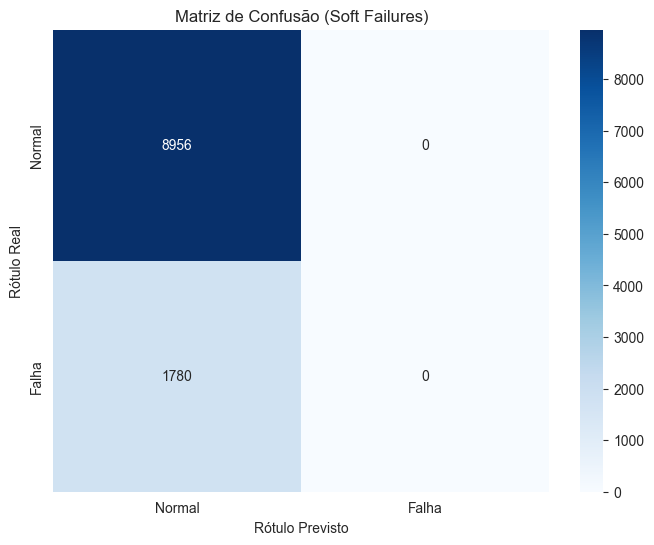

In [32]:
print("\n--- Performance da Detecção de Soft Failures ---")
print(classification_report(actual_failures, anomalies, zero_division=0))

cm = confusion_matrix(actual_failures, anomalies)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Falha'], yticklabels=['Normal', 'Falha'])
plt.title('Matriz de Confusão (Soft Failures)')
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Previsto')
plt.show()